### Predictive Maintenance Performance Metrics using Cohen’s Kappa, Wilcoxon T, and Confusion Matrices

> Analyzing and evaluating predictive maintenance models using Cohen’s Kappa, Wilcoxon T test, and confusion matrices to assess performance and reliability in predictive outcomes.

##### Cohen’s Kappa for Interrater Agreement

Cohen’s kappa measures agreement between two raters or classifiers, adjusting for agreement expected by chance. In ordered time series, it can assess how closely a model’s predicted categories align with actual labels.

##### Wilcoxon Signed-Rank Test: Paired Comparison

Wilcoxon tests compare paired, non-normally distributed samples. In ordered time series, it can test whether a model’s predicted ranks differ systematically from actual labels or whether two forecasting methods yield significantly different results in terms of ordinal error.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q numpy pandas matplotlib seaborn
!pip install -q scipy scikit-learn

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from scipy.stats import wilcoxon
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# --- Simulate health states (0: Healthy, 1: Warning, 2: Distress) ---
np.random.seed(42)
n = 200
states = [1]
for _ in range(n - 1):
    move = np.random.choice([-1, 0, 1], p=[0.1, 0.8, 0.1])
    states.append(np.clip(states[-1] + move, 0, 2))

# --- Model behavior ---
def simulate_model(true_states, direction):
    shift = lambda x: np.clip(x + np.random.choice([0, direction], p=[0.8, 0.2]), 0, 2)
    return list(map(shift, true_states))

df = pd.DataFrame({
    'True': states,
    'Model_A': simulate_model(states, direction=-1),  # Conservative
    'Model_B': simulate_model(states, direction=1)    # Aggressive
})

In [5]:
df.head()

,True,Model_A,Model_B
0,1,1,1
1,1,1,1
2,2,2,2
3,2,2,2
4,2,1,2


In [6]:
# --- Evaluation Metrics ---
def print_kappa(true, pred, label):
    kappa = cohen_kappa_score(true, pred, weights='quadratic')
    print(f"Weighted Cohen's Kappa ({label}): {kappa:.2f}")
    return kappa

kappa_a = print_kappa(df['True'], df['Model_A'], 'Model A')
kappa_b = print_kappa(df['True'], df['Model_B'], 'Model B')

Weighted Cohen's Kappa (Model A): 0.87
Weighted Cohen's Kappa (Model B): 0.82


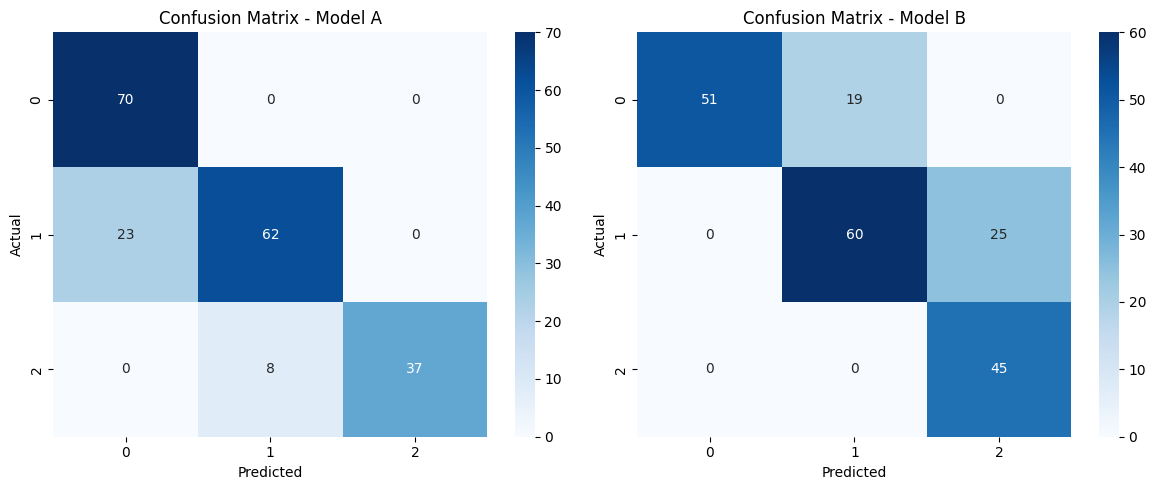

In [7]:
# Confusion Matrices
cm_a = confusion_matrix(df['True'], df['Model_A'])
cm_b = confusion_matrix(df['True'], df['Model_B'])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(cm_a, annot=True, fmt='d', ax=ax[0], cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
ax[0].set_title("Confusion Matrix - Model A")
ax[0].set_xlabel("Predicted")
ax[0].set_ylabel("Actual")

sns.heatmap(cm_b, annot=True, fmt='d', ax=ax[1], cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
ax[1].set_title("Confusion Matrix - Model B")
ax[1].set_xlabel("Predicted")
ax[1].set_ylabel("Actual")

plt.tight_layout()
# plt.savefig("confusion_matrices.png")
plt.show()

In [8]:
# --- Wilcoxon Signed-Rank Test ---
df['Error_A'] = (df['True'] - df['Model_A']).abs()
df['Error_B'] = (df['True'] - df['Model_B']).abs()
_, p_val = wilcoxon(df['Error_A'], df['Error_B'])
print(f"Wilcoxon test p-value: {p_val:.4f}")

# --- Calibration ---
calib = df[['True', 'Model_A', 'Model_B']].apply(pd.Series.value_counts, normalize=True).fillna(0).T
print("\nCalibration Summary:")
print(calib)

Wilcoxon test p-value: 0.0960

Calibration Summary:
             0      1      2
True     0.350  0.425  0.225
Model_A  0.465  0.350  0.185
Model_B  0.255  0.395  0.350


In [9]:
# Policy Impact Modeling
def decide(action):
    if action == 2:
        return 'intervene'
    elif action == 1:
        return 'review'
    return 'none'

df['Policy_A'] = df['Model_A'].apply(decide)
df['Policy_B'] = df['Model_B'].apply(decide)

def estimate_cost(policy):
    if policy == 'intervene':
        return 20
    elif policy == 'review':
        return 5
    return 0

def expected_loss(true_class, policy):
    base_risk = [10, 50, 100][true_class]
    if policy == 'intervene':
        return base_risk * 0.4
    elif policy == 'review':
        return base_risk * 0.7
    return base_risk

for model in ['A', 'B']:
    df[f'Cost_{model}'] = df[f'Policy_{model}'].apply(estimate_cost)
    df[f'ExpectedLoss_{model}'] = df.apply(lambda row: expected_loss(row['True'], row[f'Policy_{model}']), axis=1)
    df[f'Total_{model}'] = df[f'Cost_{model}'] + df[f'ExpectedLoss_{model}']

summary = df[[f'Total_A', f'Total_B']].mean().to_frame(name='Average Total Cost')
print("\nPolicy Impact Summary:")
print(summary)


Policy Impact Summary:
         Average Total Cost
Total_A               35.75
Total_B               34.19


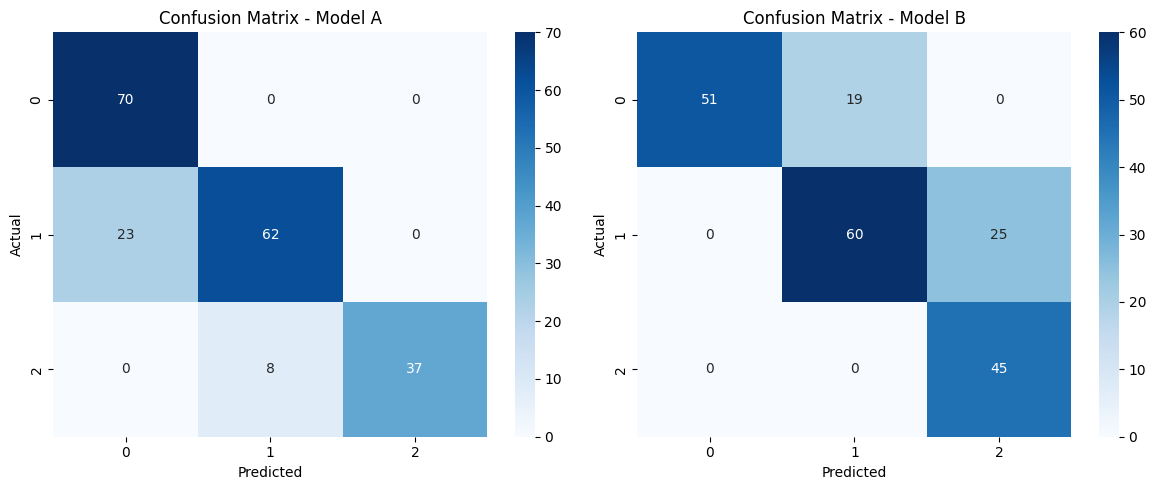

In [10]:
# --- Confusion Matrices ---
def plot_confusion(ax, true, pred, title):
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion(axes[0], df['True'], df['Model_A'], "Confusion Matrix - Model A")
plot_confusion(axes[1], df['True'], df['Model_B'], "Confusion Matrix - Model B")
plt.tight_layout()
# plt.savefig("confusion_matrices.png")
plt.show()

In [11]:
# --- Policy Impact Modeling ---
policy_map = {0: 'none', 1: 'review', 2: 'intervene'}
cost_map = {'none': 0, 'review': 5, 'intervene': 20}
base_risk = {0: 10, 1: 50, 2: 100}
risk_factor = {'none': 1.0, 'review': 0.7, 'intervene': 0.4}

for model in ['Model_A', 'Model_B']:
    policy_col = f'Policy_{model[-1]}'
    cost_col = f'Cost_{model[-1]}'
    loss_col = f'ExpectedLoss_{model[-1]}'
    total_col = f'Total_{model[-1]}'

    df[policy_col] = df[model].map(policy_map)
    df[cost_col] = df[policy_col].map(cost_map)
    df[loss_col] = df.apply(lambda row: base_risk[row['True']] * risk_factor[row[policy_col]], axis=1)
    df[total_col] = df[cost_col] + df[loss_col]

# --- Summary ---
summary = df[['Total_A', 'Total_B']].mean().to_frame(name='Average Total Cost')
print("\nPolicy Impact Summary:")
print(summary)


Policy Impact Summary:
         Average Total Cost
Total_A               35.75
Total_B               34.19
